In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install required libraries

In [ ]:
!apt-get update -y
!apt-get install -y fluidsynth libfluidsynth-dev

!pip install torchaudio librosa pyfluidsynth pretty_midi

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import os
import librosa
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm
import os
import time
import fluidsynth
import pretty_midi
import numpy as np
from scipy.io.wavfile  import write as wav_write
from scipy.signal import resample
import matplotlib.pyplot as plt
import os
import random
import matplotlib.pyplot as plt
import re

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [5,155 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,468 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd

## Preparation of audio material

In [ ]:
class AudioMaterial:
    def __init__(self):
        self.target_samplerate = 22050
        self.window_samples = 2048
        self.SFoutput = "noteNum"

    def export_all_instruments(self):
        target_length = self.window_samples * 8

        for note_number in range(21, 109):  # MIDI note 21〜108
            dir_path = f"/content/drive/MyDrive/Colab_Notebooks/88midiClassification/trainingData/{self.SFoutput}{note_number}"
            os.makedirs(dir_path, exist_ok=True)

            for program in range(1, 89):  # プログラム番号 1〜88

                # generating midi
                music = pretty_midi.PrettyMIDI()
                instrument = pretty_midi.Instrument(program=program)
                note = pretty_midi.Note(velocity=100, pitch=note_number, start=0.0, end=0.5)
                instrument.notes.append(note)
                music.instruments.append(instrument)

                # synthesize with SoundFont
                audio_data = music.fluidsynth(sf2_path="/content/drive/MyDrive/Colab_Notebooks/88midiClassification/Touhou.sf2")

                # resampling
                n_samples = int(len(audio_data) * self.target_samplerate / 44100)
                audio_data_resampled = resample(audio_data, n_samples)

                # cuting out only the required length
                if len(audio_data_resampled) < target_length:
                    print(f"⚠️ Skipped {note_number}-{program} (too short: {len(audio_data_resampled)} samples)")
                    continue

                clipped = audio_data_resampled[:target_length]

                # export
                filename = os.path.join(dir_path, f"{program:03d}_{note_number}.wav")
                if not os.path.exists(filename):
                    wav_write(filename, self.target_samplerate, (clipped * 32767).astype(np.int16))
                    print(f"✔️ {filename} Exported ({target_length} samples)")
                else:
                    print(f"⏭️ {filename} already exists.")

    def load_dataset(self, data_dir):
        paths = []
        labels = []
        class_to_idx = {}

        dir_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

        # sort numerically
        sorted_dirs = sorted(dir_names, key=lambda x: int(re.search(r'\d+', x).group()))

        print(sorted_dirs)
        for i, class_dir in enumerate(sorted_dirs):
            class_path = os.path.join(data_dir, class_dir)
            if not os.path.isdir(class_path):
                continue
            class_to_idx[class_dir] = i
            for wav_file in Path(class_path).rglob("*.wav"):
                paths.append(str(wav_file))
                labels.append(i)
        return paths, labels, class_to_idx

audio_material = AudioMaterial()

#I recommend commenting out this section once the audio data has been generated.
audio_material.export_all_instruments()

data_dir = "/content/drive/MyDrive/Colab_Notebooks/88midiClassification/trainingData"  # change to your own data
paths, labels, class_map = audio_material.load_dataset(data_dir)
train_paths, val_paths, train_labels, val_labels = train_test_split(paths, labels, test_size=0.2, stratify=labels)

['noteNum21', 'noteNum22', 'noteNum23', 'noteNum24', 'noteNum25', 'noteNum26', 'noteNum27', 'noteNum28', 'noteNum29', 'noteNum30', 'noteNum31', 'noteNum32', 'noteNum33', 'noteNum34', 'noteNum35', 'noteNum36', 'noteNum37', 'noteNum38', 'noteNum39', 'noteNum40', 'noteNum41', 'noteNum42', 'noteNum43', 'noteNum44', 'noteNum45', 'noteNum46', 'noteNum47', 'noteNum48', 'noteNum49', 'noteNum50', 'noteNum51', 'noteNum52', 'noteNum53', 'noteNum54', 'noteNum55', 'noteNum56', 'noteNum57', 'noteNum58', 'noteNum59', 'noteNum60', 'noteNum61', 'noteNum62', 'noteNum63', 'noteNum64', 'noteNum65', 'noteNum66', 'noteNum67', 'noteNum68', 'noteNum69', 'noteNum70', 'noteNum71', 'noteNum72', 'noteNum73', 'noteNum74', 'noteNum75', 'noteNum76', 'noteNum77', 'noteNum78', 'noteNum79', 'noteNum80', 'noteNum81', 'noteNum82', 'noteNum83', 'noteNum84', 'noteNum85', 'noteNum86', 'noteNum87', 'noteNum88', 'noteNum89', 'noteNum90', 'noteNum91', 'noteNum92', 'noteNum93', 'noteNum94', 'noteNum95', 'noteNum96', 'noteNum97'

## Preparing DataSet

In [ ]:
#conversion audio data to mel spectrogram
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, stride_samples):
        # self.device = device
        self.file_paths = file_paths
        self.labels = labels
        self.sample_rate = audio_material.target_samplerate
        self.window_samples = audio_material.window_samples
        self.stride_samples = stride_samples
        self.window = torch.hann_window(self.window_samples)
        self.n_fft = self.window_samples

        self.mel_scale = torchaudio.transforms.MelScale(
            n_mels=256,
            sample_rate=self.sample_rate,
            n_stft=self.n_fft // 2 + 1
        )

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]

        waveform, sr = torchaudio.load(path)
        if sr != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)
        # print(waveform.shape, "waveform")

        segments = self._create_segments_torch(waveform)
        # print(f"File: {path}, Segments shape: {segments.shape}")

        if segments.shape[0] == 0: # Check if segments is empty
            print(f"Skipping {path} due to empty segments.")
            return None, None # Return None for both features and labels


        fft_features = self._batch_fft_processing(segments)
        # print(fft_features.shape, "fft_features")

        # replicating label for each segment
        num_segments = fft_features.shape[0]
        labels_tensor = torch.full((num_segments,), label, dtype=torch.long)

        # print(labels_tensor.shape, "labels_tensor")
        return fft_features, labels_tensor


    def _create_segments_torch(self, waveform: torch.Tensor):
        """
        waveform: Tensor, shape (1, T) or (T,)
        return: Tensor, shape (num_segments, window_samples)
        Segments the waveform with sliding windows and discards leftover only if necessary.
        """
        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0)  # shape: (1, T)

        T = waveform.shape[1]

        if T < self.window_samples:
            print(f"  Waveform too short: {T} < {self.window_samples}")
            return torch.empty((0, self.window_samples), device=waveform.device)

        # calculating the remainder
        remainder = (T - self.window_samples) % self.stride_samples
        if remainder > 0:
            max_len = T - remainder
            waveform = waveform[:, :max_len]
            print(f"  Truncated waveform length: {max_len}")


        # segmentation by unfold
        segments = waveform.unfold(dimension=1, size=self.window_samples, step=self.stride_samples)
        segments = segments.squeeze(0)  # shape: (num_segments, window_samples)

        return segments


    def _batch_fft_processing(self, segments):

        segments = self._normalize_audio(segments)

        windowed_segments = segments * self.window
        fft_results = torch.fft.fft(windowed_segments, n=self.n_fft)

        magnitudes = torch.abs(fft_results[:, :self.n_fft // 2 + 1])   # Positive frequency only

        #conversion to Mel Scale
        mel_spectrogram = self.mel_scale(magnitudes.T).T

        # logarithmic transformation
        log_mel = torch.log(mel_spectrogram + 1e-10)

        # feature normalization
        # normalized_features = self._normalize_features(log_mel)

        return log_mel


    def _normalize_audio(self, segments):
        # RMS normalization
        rms = torch.sqrt(torch.mean(segments ** 2, dim=1, keepdim=True))
        segments = segments / (rms + 1e-10)

        # maximum value limit
        segments = torch.clamp(segments, -1.0, 1.0)

        return segments



    # def _normalize_features(self, features):
    #
    #     # Z-score normalization for each segment
    #     mean = torch.mean(features, dim=1, keepdim=True)
    #     std = torch.std(features, dim=1, keepdim=True)
    #     normalized = (features - mean) / (std + 1e-10)

    #     # range-valued limit
    #     normalized = torch.clamp(normalized, -3.0, 3.0)

    #     return normalized

num_classes = len(class_map)
stride_samples = audio_material.window_samples

print(f"num_classes: {num_classes}")
print(f"train_paths: {len(train_paths)}")
print(f"val_paths: {len(val_paths)}")

train_dataset = AudioDataset(train_paths, train_labels, stride_samples)
val_dataset = AudioDataset(val_paths, val_labels, stride_samples)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=True) # Changed shuffle to False for validation

num_classes: 88
train_paths: 6195
val_paths: 1549


## Model

In [ ]:
class AudioCNN1D(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN1D, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.AdaptiveAvgPool1d(1)  # [B, 64, 1]

        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: (B, 1, N)
        # print(x.shape, "x.shape1")
        x = self.pool1(F.relu(self.conv1(x)))  # → (B, 16, N/2)
        # print(x.shape, "x.shape2")
        x = self.pool2(F.relu(self.conv2(x)))  # → (B, 32, N/4)
        # print(x.shape, "x.shape3")
        x = self.pool3(F.relu(self.conv3(x)))  # → (B, 64, 1)
        # print(x.shape, "x.shape4")

        x = x.squeeze(-1)  # → (B, 64)
        x = self.fc(x)     # → (B, num_classes)
        # print(x.shape, "x.shape5")
        return x


## Train

cpu


  0%|          | 0/96 [00:00<?, ?it/s]

torch.Size([64, 8, 256])


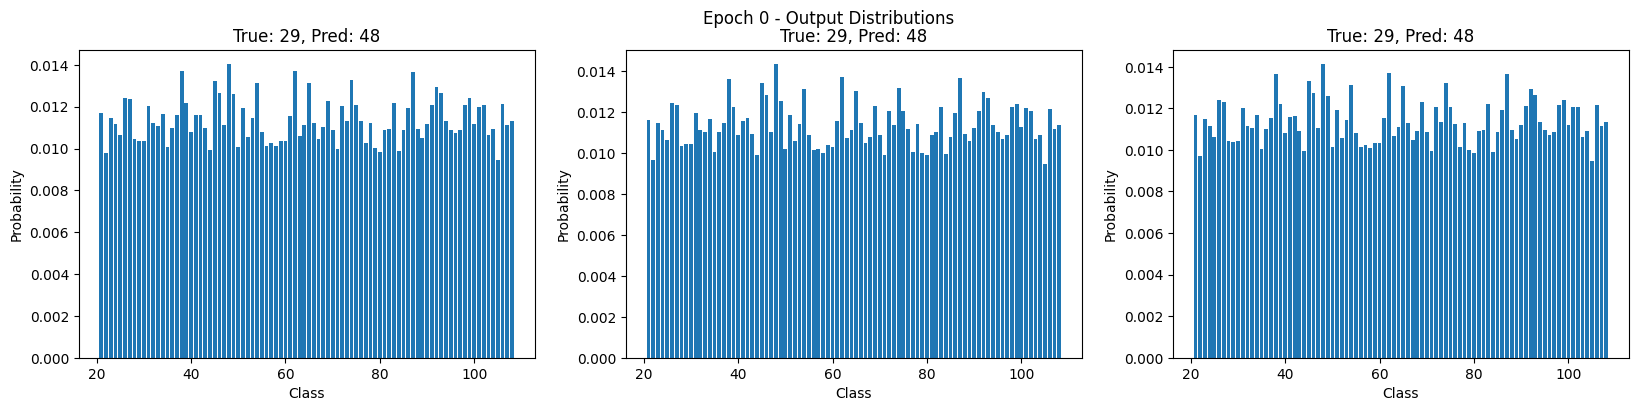

  1%|          | 1/96 [00:20<31:48, 20.09s/it]

torch.Size([64, 8, 256])


  3%|▎         | 3/96 [00:56<28:59, 18.71s/it]

torch.Size([64, 8, 256])


  4%|▍         | 4/96 [01:13<27:18, 17.81s/it]

torch.Size([64, 8, 256])


  4%|▍         | 4/96 [01:16<29:09, 19.02s/it]


KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = AudioCNN1D(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

epochs = 120
for epoch in range(epochs):
   # === Training Phase ===
    model.train()
    running_loss = 0.0
    correct = 0

#With tqbm, the progress of the batch study is displayed in a bar in the terminal
    for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        optimizer.zero_grad()
        print(inputs.shape)
        batch_size, num_divisions, num_bins = inputs.shape

        # reshape for CNN: (batch_size * max_segments, 1, num_bins)
        inputs = inputs.view(-1, 1, num_bins)

        outputs = model(inputs)
        # print("expanded_labels ", labels.shape, "outputs ", outputs.shape)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy per segment
        predicted_segments = outputs.argmax(1)
        correct += (predicted_segments == labels).sum().item()

        # plots (first batch only, every 10 epochs)
        if batch_idx == 0:
            probs = F.softmax(outputs, dim=1).detach().cpu()
            fig, axes = plt.subplots(1, 3, figsize=(20, 4))
            for i in range(3):
                axes[i].bar(range(21, 109), probs[i])
                axes[i].set_title(f"True: {labels[i].item()+21}, Pred: {predicted_segments[i].item()+21}")
                axes[i].set_xlabel("Class")
                axes[i].set_ylabel("Probability")
            plt.suptitle(f"Epoch {epoch} - Output Distributions")
            plt.show()



    train_acc = correct / (len(train_dataset) * num_divisions) # Adjust accuracy calculation

    # === Verification Phase ===
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.view(-1)
            batch_size, num_divisions, num_bins = inputs.shape
            inputs = inputs.view(-1, 1, num_bins)

            outputs = model(inputs)
            val_correct += (outputs.argmax(1) == labels).sum().item() # Compare with expanded labels

    val_acc = val_correct / (len(val_dataset) * num_divisions) # Adjust accuracy calculation

    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}")

# === Saving the model after training ===
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/88midiClassification/model/audio_cnn_modelV3_IR0002.pth")
print("Model saved to audio_cnn_model.pth")

## Inference (checking probability distributions)

Segments shape: {segments.shape}
torch.Size([8, 256]) fft_features
torch.Size([8, 1, 256]) input_tensor


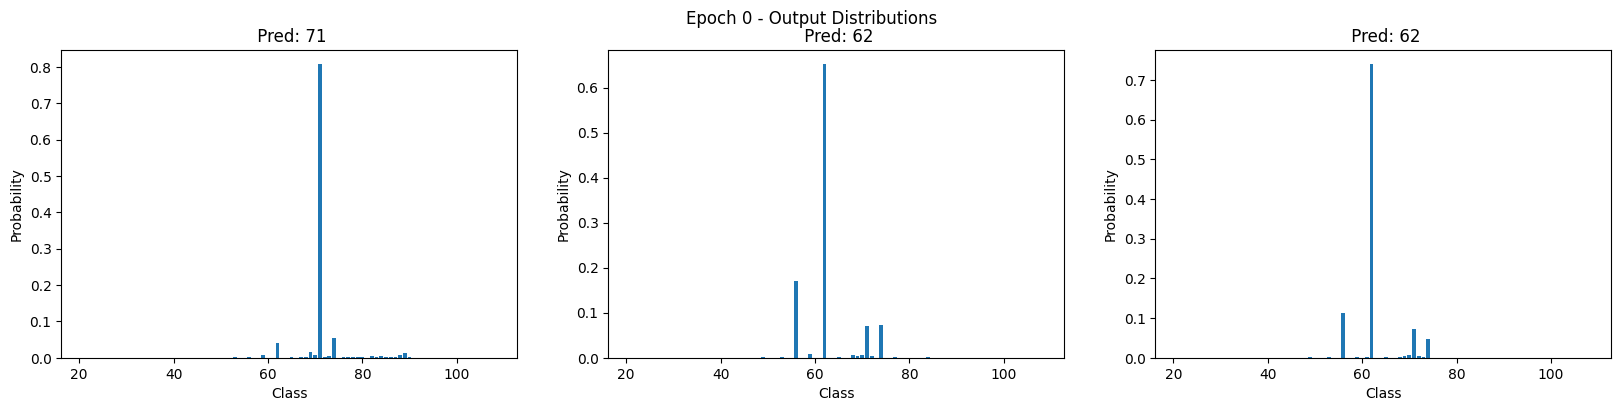

In [ ]:

def checking_probability_distributions (audio_path, model_path):

    # model definition and loading
    model = AudioCNN1D(num_classes)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.to(device)
    model.eval()



    # audio file loading and preprocessing
    waveform, sr = torchaudio.load(audio_path)
    sample_rate =  audio_material.target_samplerate
    if sr != sample_rate:
        waveform = torchaudio.functional.resample(waveform, sr, sample_rate)


    # to mono (if there are multiple channels)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # segment creation (with the same process as in the study)
    segments = train_dataset._create_segments_torch(waveform)
    print("Segments shape: {segments.shape}")

    #FFT conversion
    fft_features = train_dataset._batch_fft_processing(segments)
    print(fft_features.shape, "fft_features")

    input_tensor = fft_features.unsqueeze(0)  # Add batch dim → [1, num_segments, num_bins]

    # preprocessing and Inference
    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        batch_size, num_segments, num_bins = input_tensor.shape
        input_tensor = input_tensor.view(-1, 1, num_bins)  # [batch * segments, 1, num_bins]

        print(input_tensor.shape, "input_tensor")
        outputs = model(input_tensor)  # shape: [segments, 88]
        probs = F.softmax(outputs, dim=1)
        max = torch.argmax(probs, dim=1)

        fig, axes = plt.subplots(1, 3, figsize=(20, 4))

        #The first three frames of the input audio are taken and their respective probability distributions are plotted.
        for i in range(3):
            axes[i].bar(range(21, 109), probs[i].cpu().numpy())
            axes[i].set_title(f" Pred: {max[i].item()+21}")
            axes[i].set_xlabel("Class")
            axes[i].set_ylabel("Probability")
        plt.suptitle(f"Epoch {epoch} - Output Distributions")
        plt.show()

audio_path = "/content/drive/MyDrive/Colab_Notebooks/88midiClassification/trainingData/noteNum62/012_62.wav"
model_path = "/content/drive/MyDrive/Colab_Notebooks/88midiClassification/model/audio_cnn_modelV3_IR0002.pth"
checking_probability_distributions(audio_path, model_path)



## Inference (sliding window inference)

1024
Segments shape: torch.Size([15, 2048])
Number of frames: 15


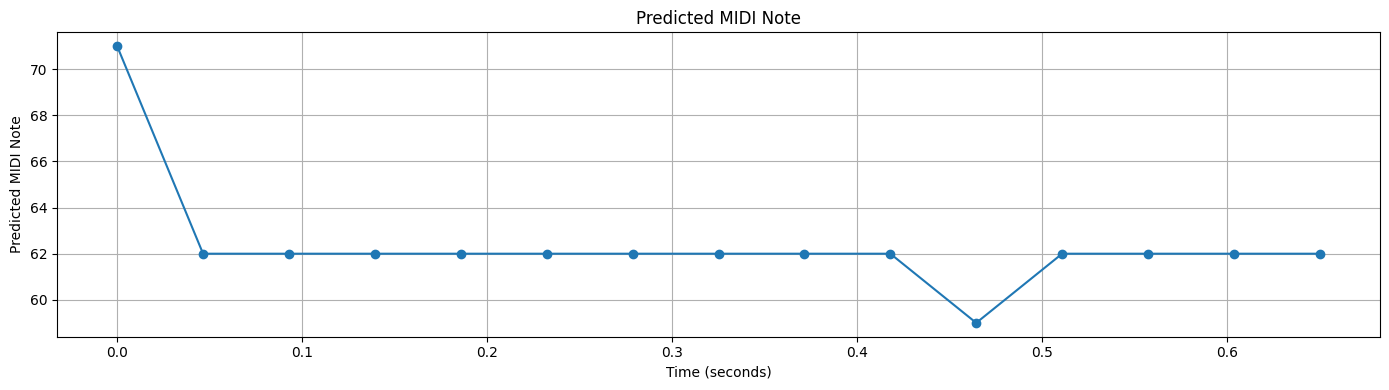

In [ ]:
def checking_probability_distributions(audio_path, model_path, inference_data):
    # model definition and loading
    model = AudioCNN1D(num_classes)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.to(device)
    model.eval()

    # audio file loading and preprocessing
    waveform, sr = torchaudio.load(audio_path)
    sample_rate = audio_material.target_samplerate
    if sr != sample_rate:
        waveform = torchaudio.functional.resample(waveform, sr, sample_rate)

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # segment creation (with the same process as in the study)
    segments = inference_data._create_segments_torch(waveform)  # shape: [num_segments, 1, 2048]
    print(f"Segments shape: {segments.shape}")
    num_frames = segments.shape[0]
    print(f"Number of frames: {num_frames}")

    # FFT conversion
    fft_features = inference_data._batch_fft_processing(segments)  # shape: [num_segments, num_bins]
    input_tensor = fft_features.unsqueeze(0).to(device)  # [1, num_segments, num_bins]
    input_tensor = input_tensor.view(-1, 1, fft_features.shape[1])  # [num_segments, 1, num_bins]

    # inference
    with torch.no_grad():
        outputs = model(input_tensor)  # shape: [num_segments, num_classes]
        preds = torch.argmax(outputs, dim=1).cpu().numpy()


    # calculation time axis in seconds
    times = [i * stride_samples / sample_rate for i in range(num_frames)]

    # Plot classification results in time series
    plt.figure(figsize=(14, 4))
    plt.plot(times, preds + 21, marker='o')
    plt.title("Predicted MIDI Note")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Predicted MIDI Note")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


audio_path = "/content/drive/MyDrive/Colab_Notebooks/88midiClassification/trainingData/noteNum62/012_62.wav"
model_path = "/content/drive/MyDrive/Colab_Notebooks/88midiClassification/model/audio_cnn_modelV3_IR0002.pth"
#At training, the overlap is 0%, but at inference, it is set to 50%.
stride_samples =int(audio_material.window_samples / 2)
print(stride_samples)
inference_data = AudioDataset(train_paths, train_labels, stride_samples)
checking_probability_distributions(audio_path, model_path, inference_data)
